In [423]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates



In [256]:
l_scaling = ['regression']
nl_scaling = ['distance_correlation']
scaling_methods = l_scaling + nl_scaling

l_dim = ['pca']
nl_dim = ['rbf']
dim_methods = l_dim + nl_dim

l_reg = ['ols']
nl_reg = ['svr']
reg_methods = l_reg + nl_reg

horizons = [1,6,12]

targets =  ['inflation', 'unemployment']
forecasts = pd.DataFrame(columns=['forecast', 'actual', 'target', 'horizon', 'scaling', 'dim_red', 'regression', 'month'])

for scaling in scaling_methods:
    for dim_red in dim_methods:
        for regression in reg_methods:
            for horizon in horizons:
                for target in targets:
                    forecast = np.load('resources/results/forecasts_good/{}_{}_{}_{}_h{}.npy'.format(target, dim_red, scaling, regression, horizon))
                    actual = np.load('resources/results/forecasts_good/{}_actual_h{}.npy'.format(target, horizon))
                    ar_forecast = np.load('resources/results/forecasts_good/{}_AR_h{}.npy'.format(target, horizon))
                    
                    r2_denom = np.mean((actual - np.mean(actual))**2)
                    for t in range(len(forecast)):
                        forecasts = forecasts.append({'forecast': forecast[t][0],'actual': actual[t][0], 'target': target, 'horizon': horizon, 'scaling': scaling,
                                                      'dim_red': dim_red, 'regression': regression, 'var_target':r2_denom, 'month':t, 'ar':ar_forecast[t][0]}, ignore_index=True)  

In [283]:
forecasts = forecasts_og

In [284]:
forecasts['errors'] = (forecasts['forecast'] - forecasts['actual'])**2
forecasts['r2'] = 1 - forecasts['errors']/forecasts['var_target']
forecasts['r2oos'] = 1 - forecasts['errors']/np.mean((forecasts['ar'] - forecasts['actual'])**2)
forecasts.head(10)

,forecast,actual,target,horizon,scaling,dim_red,regression,month,ar,var_target,nonlin_scaling,nonlin_dimred,nonlin_reg,interaction,hv,model_combs,errors,r2,r2oos
0,0.001825,0.005711,inflation,1,regression,pca,ols,0,0.002343,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000015,-0.774445,0.998763
1,0.003137,0.002275,inflation,1,regression,pca,ols,1,0.003890,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000001,0.912697,0.999939
2,0.002707,0.000568,inflation,1,regression,pca,ols,2,0.003417,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000005,0.462378,0.999625
3,0.001383,0.001702,inflation,1,regression,pca,ols,3,0.002359,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.0,0.988026,0.999992
4,0.002055,0.005089,inflation,1,regression,pca,ols,4,0.001897,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000009,-0.081321,0.999246
5,0.003717,0.002254,inflation,1,regression,pca,ols,5,0.003321,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000002,0.748311,0.999825
6,0.002225,-0.00169,inflation,1,regression,pca,ols,6,0.003147,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000015,-0.800995,0.998745
7,0.000833,0.0,inflation,1,regression,pca,ols,7,0.001341,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000001,0.918413,0.999943
8,0.001135,0.003938,inflation,1,regression,pca,ols,8,0.000661,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000008,0.076571,0.999356
9,0.000183,-0.002811,inflation,1,regression,pca,ols,9,0.002105,0.000009,0,0,0,0_0_0,1_inflation,regression_pca_ols,0.000009,-0.053578,0.999266


In [265]:
# Compute MSE per horizon, target, scaling, dim_red, regression
def mse(g):
    mse = np.mean((g['forecast'] - g['actual'])**2)
    return pd.Series(dict(mse = mse))


forecasts.groupby(['target', 'horizon', 'scaling', 'dim_red', 'regression']).apply(mse)*100

mse
target       horizon scaling              dim_red regression          
inflation    1       distance_correlation pca     ols         0.000681
                                                  svr         0.000872
                                          rbf     ols         0.000699
                                                  svr         0.000879
                     regression           pca     ols         0.000658
                                                  svr         0.000946
                                          rbf     ols         0.000658
                                                  svr         0.000805
             6       distance_correlation pca     ols         0.001204
                                                  svr         0.000940
                                          rbf     ols         0.001173
                                                  svr         0.000921
                     regression           pca     ols         0.001202
                                                  svr         0.000980
                                          rbf     ols         0.001202
                                                  svr         0.000869
             12      distance_correlation pca     ols         0.001234
                                                  svr         0.001002
                                          rbf     ols         0.001180
                                                  svr         0.001001
                     regression           pca     ols         0.001208
                                                  svr         0.001200
                                          rbf     ols         0.001208
                                                  svr         0.001030
unemployment 1       distance_correlation pca     ols         1.917785
                                                  svr         2.191501
                                          rbf     ols         1.866632
                                                  svr         2.236856
                     regression           pca     ols         1.955675
                                                  svr         2.236268
                                          rbf     ols         1.957390
                                                  svr         2.287692
             6       distance_correlation pca     ols         2.489413
                                                  svr         2.456861
                                          rbf     ols         2.477843
                                                  svr         2.474348
                     regression           pca     ols         2.454280
                                                  svr         2.468202
                                          rbf     ols         2.454280
                                                  svr         2.444953
             12      distance_correlation pca     ols         2.590979
                                                  svr         2.492648
                                          rbf     ols         2.581716
                                                  svr         2.546879
                     regression           pca     ols         2.625972
                                                  svr         2.519880
                                          rbf     ols         2.625846
                                                  svr         2.546959

In [285]:
# Create dummies for nonlinear scaling, dimred, reg
forecasts['nonlin_scaling'] = forecasts['scaling'].apply(lambda x: 1 if x in nl_scaling else 0)
forecasts['nonlin_dimred'] = forecasts['dim_red'].apply(lambda x: 1 if x in nl_dim else 0)
forecasts['nonlin_reg'] = forecasts['regression'].apply(lambda x: 1 if x in nl_reg else 0)

# Create variable to use as index, representing each of 8 groups
interactions = forecasts['nonlin_scaling'].astype(str) + "_" + forecasts['nonlin_dimred'].astype(str) + "_" + forecasts['nonlin_reg'].astype(str)
forecasts['interaction'] = interactions

hv_combs = forecasts['horizon'].astype(str) + "_" + forecasts['target'].astype(str)
forecasts['hv'] = hv_combs

model_comb = forecasts['scaling'].astype(str) + "_" + forecasts['dim_red'].astype(str) + "_" + forecasts['regression'].astype(str)

# Make categorical
forecasts['horizon'] = pd.Categorical(forecasts['horizon'])
forecasts['interaction'] = pd.Categorical(forecasts['interaction'])
forecasts['target'] = pd.Categorical(forecasts['target'])
forecasts['model_combs'] = pd.Categorical(model_comb)

# Set index
#forecasts = forecasts.set_index(['model_combs', 'month'])
#forecasts.head(5)

In [272]:
# Regress the R2 on the dummies
h_v = list(itertools.product(horizons, targets))

for h, v in h_v:
    print(f"horizon{h}, target{v}")
    data = forecasts[(forecasts['horizon']) == h & (forecasts['target'] == v)]
    data = forecasts.copy()
    data = convert_categorical_to_dummies(data)
    print(data.columns)
    mod = PanelOLS(data.r2, exog=data[['nonlin_reg', 'nonlin_scaling', 'nonlin_dimred']],
                   entity_effects=False, time_effects=True)
    #res = mod.fit()
    #mod = sm.OLS(data['r2'], data[['nonlin_reg', 'nonlin_scaling', 'nonlin_dimred']].astype(float))
    res = mod.fit()
    
    print(res)

horizon1, targetinflation
Index(['forecast', 'actual', 'scaling', 'dim_red', 'regression', 'ar',
       'var_target', 'errors', 'r2', 'r2oos', 'nonlin_scaling',
       'nonlin_dimred', 'nonlin_reg', 'hv', 'target_inflation',
       'target_unemployment', 'horizon_1', 'horizon_6', 'horizon_12',
       'interaction_0_0_0', 'interaction_0_0_1', 'interaction_0_1_0',
       'interaction_0_1_1', 'interaction_1_0_0', 'interaction_1_0_1',
       'interaction_1_1_0', 'interaction_1_1_1',
       'model_combs_distance_correlation_pca_ols',
       'model_combs_distance_correlation_pca_svr',
       'model_combs_distance_correlation_rbf_ols',
       'model_combs_distance_correlation_rbf_svr',
       'model_combs_regression_pca_ols', 'model_combs_regression_pca_svr',
       'model_combs_regression_rbf_ols', 'model_combs_regression_rbf_svr'],
      dtype='object')
                          PooledOLS Estimation Summary                          
Dep. Variable:                     r2   R-squared:        

Index(['forecast', 'actual', 'scaling', 'dim_red', 'regression', 'ar',
       'var_target', 'errors', 'r2', 'r2oos', 'nonlin_scaling',
       'nonlin_dimred', 'nonlin_reg', 'hv', 'target_inflation',
       'target_unemployment', 'horizon_1', 'horizon_6', 'horizon_12',
       'interaction_0_0_0', 'interaction_0_0_1', 'interaction_0_1_0',
       'interaction_0_1_1', 'interaction_1_0_0', 'interaction_1_0_1',
       'interaction_1_1_0', 'interaction_1_1_1',
       'model_combs_distance_correlation_pca_ols',
       'model_combs_distance_correlation_pca_svr',
       'model_combs_distance_correlation_rbf_ols',
       'model_combs_distance_correlation_rbf_svr',
       'model_combs_regression_pca_ols', 'model_combs_regression_pca_svr',
       'model_combs_regression_rbf_ols', 'model_combs_regression_rbf_svr'],
      dtype='object')
                          PooledOLS Estimation Summary                          
Dep. Variable:                     r2   R-squared:                     4.651e-05
Est

In [273]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [400]:
from arch.bootstrap import SPA, MCS

In [409]:
for horizon in horizons:
    for target in targets:
        df = forecasts[(forecasts['horizon'] == horizon) & (forecasts['target'] == target)]

        benchmark = df['ar'][(df['scaling'] == 'regression') & (df['dim_red'] == "pca") & (df['regression'] == "ols")]
        actual = df['actual'][(df['scaling'] == 'regression') & (df['dim_red'] == "pca") & (df['regression'] == "ols")]
        df = df[['forecast', 'model_combs' ]]
        df['index'] = df.groupby('model_combs').cumcount()
        df = df.pivot(index='index', values='forecast', columns='model_combs')
        df = df.reset_index(drop=True)
        models = list(df.columns) + ['AR']
        
        bm_losses = benchmark - actual # Correct shape
        model_losses = df - actual.values.reshape(-1, 1) # Correct shape
        
        bm_losses = np.array(bm_losses.values**2, dtype=np.float64)
        model_losses = np.array(model_losses.values**2, dtype=np.float64)
        
        #bm_losses = np.zeros((227,1))
        #model_losses = np.zeros((227, 5))
                
        spa = SPA(bm_losses, model_losses, seed=42)
        spa.compute()
        print(f"Horizon {horizon} and target {target}")
        print(spa.pvalues)
        
        model_losses = np.append(model_losses, bm_losses.reshape(-1, 1), axis=1)
        mcs = MCS(losses=model_losses, size=0.2)
        mcs.compute()
        
        print("MCS P-values")
        print(mcs.pvalues)
        
        print("MCS Included")
        included = mcs.included
        print([models[model] for model in included])    
        
        print("MCS Excluded")
        excluded = mcs.excluded
        print([models[model] for model in excluded])    

        print("______________________________________")
        

Horizon 1 and target inflation
lower         0.012
consistent    0.031
upper         0.031
dtype: float64
MCS P-values
             Pvalue
Model index        
8             0.101
0             0.203
2             0.249
3             0.279
7             0.279
1             0.279
5             0.279
4             0.721
6             1.000
MCS Included
['distance_correlation_pca_ols', 'distance_correlation_pca_svr', 'distance_correlation_rbf_ols', 'distance_correlation_rbf_svr', 'regression_pca_ols', 'regression_pca_svr', 'regression_rbf_ols', 'regression_rbf_svr']
MCS Excluded
['AR']
______________________________________
Horizon 1 and target unemployment
lower         0.029
consistent    0.029
upper         0.029
dtype: float64
MCS P-values
             Pvalue
Model index        
8             0.118
6             0.297
0             0.297
4             0.297
3             0.297
7             0.297
5             0.413
1             0.413
2             1.000
MCS Included
['distance_correl

In [442]:
def generate_dates(n):
    # start date is December 2019
    start_date = datetime(2019, 12, 1)

    # list to hold the dates
    dates = []

    for i in range(n):
        # subtract i months from the start date
        new_date = start_date - relativedelta(months=i)
        # format the date as <month-year> and append it to the list
        dates.append(new_date.strftime('%m-%Y'))

    return dates

# Cumulative sum of difference in squared errors
def plot_cssed(benchmark, model):
    diff = np.cumsum(benchmark - model)
    dates = generate_dates(diff.shape[0])
    
    dates = [datetime.strptime(date, '%m-%Y') for date in dates]
    
    fig, ax = plt.subplots()
    ax.plot(dates, diff[::-1])
    
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.xlabel('Period')
    plt.ylabel('Cumulative sum of difference in errors^2')
    plt.show()

Horizon:1 Target:inflation
distance_correlation_pca_ols vs distance_correlation_pca_svr


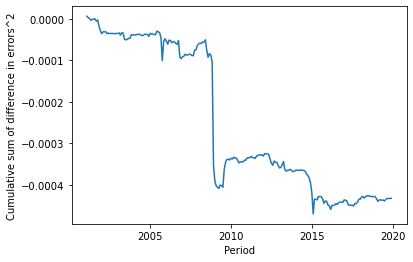

Horizon:6 Target:inflation
distance_correlation_pca_ols vs distance_correlation_pca_svr


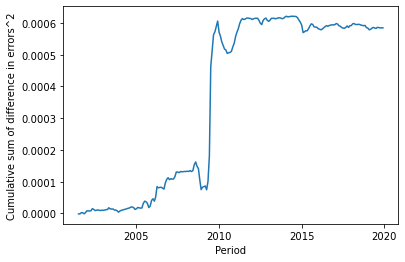

Horizon:12 Target:inflation
distance_correlation_pca_ols vs distance_correlation_pca_svr


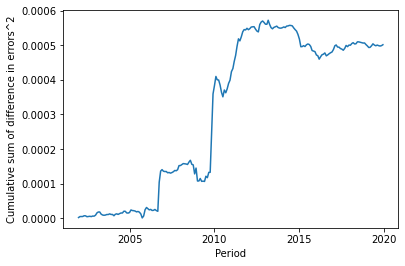

In [445]:
for horizon in horizons:
    for target in targets:
        print("Horizon:{} Target:{}".format(horizon, target))
        df = forecasts[(forecasts['horizon'] == horizon) & (forecasts['target'] == target)]

        benchmark = df['ar'][(df['scaling'] == 'regression') & (df['dim_red'] == "pca") & (df['regression'] == "ols")]
        actual = df['actual'][(df['scaling'] == 'regression') & (df['dim_red'] == "pca") & (df['regression'] == "ols")]
        df = df[['forecast', 'model_combs' ]]
        df['index'] = df.groupby('model_combs').cumcount()
        df = df.pivot(index='index', values='forecast', columns='model_combs')
        df = df.reset_index(drop=True)
        models = list(df.columns) + ['AR']
        
        bm_losses = benchmark - actual # Correct shape
        model_losses = df - actual.values.reshape(-1, 1) # Correct shape
        
        bm_losses = np.array(bm_losses.values**2, dtype=np.float64)
        model_losses = np.array(model_losses.values**2, dtype=np.float64)
        
        print(models[0], "vs", models[1])
        plot_cssed(benchmark=model_losses[:,0], model=model_losses[:,1])
        break
